<a href="https://colab.research.google.com/github/kidrono/AutoMix-DMC-implementation/blob/main/dmc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import os
from torch import nn
import tarfile
from pathlib import Path
import matplotlib.pyplot as plt
import glob
import torchaudio
from IPython.display import Audio

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Preprocess the data - ENST-Drum data set
The dataset contains the recording of 3 different drummers.
Each drummer recoreded several short beats and feels on drum-set.
The data is ordered like that:

ENST_drums-->drummer-->audio-->track_name-->wav file.

We will regard to the "wet_mix" track as our label (or target) track.
We want to get the paths of all the relevant wav files and divide it to raw tracks and target tracks.


In [3]:
data_path = Path("data")

if data_path.is_dir():
  print("already exists")
else:
  data_path.mkdir(parents=True, exist_ok=True)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
!gdown "1F_dYm6pKNEcDXdK87tAFByNU1pqwi9qp&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1F_dYm6pKNEcDXdK87tAFByNU1pqwi9qp&confirm=t
To: /content/ENST-drums.tar
100% 5.28G/5.28G [00:40<00:00, 131MB/s]


In [6]:
drum_path = data_path / "ENST-drums"

if drum_path.is_dir():
  print("already exists")
else:
  with tarfile.open("ENST-drums.tar", 'r') as tar_ref:
    tar_ref.extractall(data_path)

In [7]:
def walk_through_dir(dir_path):
  for dirpath, dirname, filename in os.walk(dir_path):
    print(f"There are {len(dirname)} directories and {len(filename)} files in {dirpath}")

In [8]:
walk_through_dir(drum_path)

There are 3 directories and 1 files in data/ENST-drums
There are 2 directories and 0 files in data/ENST-drums/drummer_1
There are 0 directories and 97 files in data/ENST-drums/drummer_1/annotation
There are 10 directories and 1 files in data/ENST-drums/drummer_1/audio
There are 0 directories and 97 files in data/ENST-drums/drummer_1/audio/overhead_L
There are 0 directories and 97 files in data/ENST-drums/drummer_1/audio/hi-hat
There are 0 directories and 97 files in data/ENST-drums/drummer_1/audio/dry_mix
There are 0 directories and 97 files in data/ENST-drums/drummer_1/audio/kick
There are 0 directories and 97 files in data/ENST-drums/drummer_1/audio/tom_1
There are 0 directories and 97 files in data/ENST-drums/drummer_1/audio/overhead_R
There are 0 directories and 97 files in data/ENST-drums/drummer_1/audio/snare
There are 0 directories and 97 files in data/ENST-drums/drummer_1/audio/accompaniment
There are 0 directories and 97 files in data/ENST-drums/drummer_1/audio/tom_2
There are

In [9]:
pth = Path("data/ENST-drums/")
# lst = list(os.walk(pth))
# pths_lst = lst[0][2]
# pths_lst.sort(key=str.lower)
# new_pth = pth + Path(pths_lst[0])
# new_pth
mixes_directory = "wet_mix"
mixes = list(Path(pth).glob("*/audio/" + mixes_directory +"/*.wav"))
mixes[2].parents[1]


PosixPath('data/ENST-drums/drummer_1/audio')

In [10]:
from os.path import isfile
def filter_mixes(root_dir: str,
                 mix_dir: str,
                 length: int=None):
  # get all mixes paths of all the drummers
  all_mixes = list(Path(root_dir).glob("*/audio/" + mix_dir +"/*.wav"))
  # remove mixes that are only hits
  mixes_without_hits = [mix_pth for mix_pth in all_mixes if "hits" not in mix_pth.stem]
  # remove too short mixes
  if length:
    mixes_long_enough = [mix_pth for mix_pth in mixes_without_hits if torchaudio.info(mix_pth).num_frames < length]
    return mixes_long_enough
  else:
    return mixes_without_hits

def get_tracks_paths(track_names: list, mix_path):
    wav_name = mix_path.name
    start_path = mix_path.parents[1]
    paths = []
    for track_name in track_names:
      path = start_path.joinpath(track_name, wav_name)
      if os.path.isfile(path):
        paths.append(path)
    return paths

In [11]:
tracks = ["kick", "tom_3", "snare"]
mix_pth = mixes[4]
get_tracks_paths(tracks, mix_pth)

[PosixPath('data/ENST-drums/drummer_1/audio/kick/005_hits_bass-drum_pedal_x5.wav'),
 PosixPath('data/ENST-drums/drummer_1/audio/snare/005_hits_bass-drum_pedal_x5.wav')]

In [12]:
class ENSTDrumDataset(torch.utils.data.Dataset):

  def __init__(self,
               root_dir: str,
               mix_dir: str,
               sr: int,
               min_length: int=None) -> None:
    super().__init__()
    self.root_dir = root_dir
    self.mix_dir = mix_dir
    self.min_length = min_length
    self.sr = sr
    self.track_names = ["kick", "snare", "hi-hat", "overhead_L",
                        "overhead_R", "tom_1", "tom_2", "tom_3"]
    self.mixes = filter_mixes(root_dir, mix_dir, min_length)

  def __getitem__(self, index:int=None):
    if index is None:
      index = int(torch.randint(0, len(self.mixes), (1,1)))
    mix_path = self.mixes[index]
    tracks_paths = get_tracks_paths(self.track_names, mix_path)
    # now load the mix and the tracks
    y, sr = torchaudio.load(mix_path, 0, self.min_length)
    x = []
    for path in tracks_paths:
      x_new, sr = torchaudio.load(path, 0, self.min_length)
      x.append(x_new)
    x = torch.stack(x)
    return x, y, mix_path.name

## Visualize the data
Let's feel the data with some examples and spectograms

In [13]:
drums_data = ENSTDrumDataset(Path("data/ENST-drums/"), "wet_mix", 44100)
to_play = drums_data[8]
print(to_play[2])
Audio(to_play[1].numpy()[0], rate=44100)

049_phrase_afro_simple_medium_mallets.wav


In [14]:
# play just one track from the complete mix
Audio(to_play[0].numpy()[0], rate=44100)

In [15]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    plt.show(block=False)

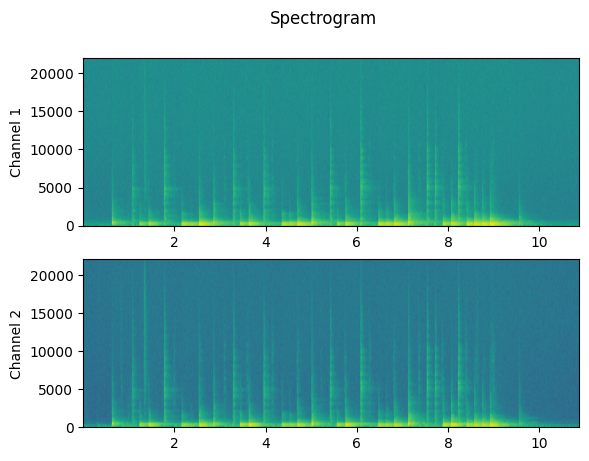

In [16]:
plot_specgram(to_play[1], 44100)

# Building the Differential Mixing Console:
The model is based on 3 main components:

1 - encoder

2 - post-processor

3 - mixer (transformation network)

In [17]:
class ResBlock(nn.Module):

  def __init__(self, input: int, output: int, kernel=3, stride=2, pad=1) -> None:
    super().__init__()
    self.input = input
    self.output = output
    self.conv_layer1 = nn.Conv2d(in_channels=input, out_channels=output,
                                 kernel_size=kernel, stride=stride,
                                 padding=pad)
    self.conv_layer2 = nn.Conv2d(in_channels=output, out_channels=output,
                                 kernel_size=kernel, stride=stride,
                                 padding=pad)
    self.relu = nn.ReLU()

  def should_apply_shortcut(self):
    return self.input != self.output

  def forward(self, x):
    residual = x
    f_x = self.conv_layer1(x)
    f_x = self.relu(f_x)
    f_x = self.conv_layer2(f_x)
    f_x = self.relu(f_x)
    if self.should_apply_shortcut():
      f_x += residual
    return f_x

In [18]:
resblock = ResBlock(1, 1)
dummy = torch.ones((1, 1, 1, 1))
resblock(dummy)

tensor([[[[0.1810]]]], grad_fn=<ReluBackward0>)

## The Encoder:

First we download the pretrained models for the encoder,
and then we build the encoder architecture that based on
"Short-Chunk CNN with Residual blocks"

---



In [19]:
os.makedirs("checkpoints", exist_ok=True)
!wget https://huggingface.co/csteinmetz1/automix-toolkit/resolve/main/encoder.ckpt
!mv encoder.ckpt checkpoints/encoder.ckpt
encoder_ckpt_path = "checkpoints/encoder.ckpt"

--2023-06-14 12:47:19--  https://huggingface.co/csteinmetz1/automix-toolkit/resolve/main/encoder.ckpt
Resolving huggingface.co (huggingface.co)... 65.9.86.43, 65.9.86.34, 65.9.86.104, ...
Connecting to huggingface.co (huggingface.co)|65.9.86.43|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/ec/ee/ecee38df047e3f2db1bd8c31a742f3a08f557470cd67cb487402a9c3ed91b5ea/90c13ab981715e1fc1ae079f15fb6da36d61d6aad29ae5dddd4d3bfd4594546a?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27encoder.ckpt%3B+filename%3D%22encoder.ckpt%22%3B&Expires=1687006040&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly9jZG4tbGZzLmh1Z2dpbmdmYWNlLmNvL3JlcG9zL2VjL2VlL2VjZWUzOGRmMDQ3ZTNmMmRiMWJkOGMzMWE3NDJmM2EwOGY1NTc0NzBjZDY3Y2I0ODc0MDJhOWMzZWQ5MWI1ZWEvOTBjMTNhYjk4MTcxNWUxZmMxYWUwNzlmMTVmYjZkYTM2ZDYxZDZhYWQyOWFlNWRkZGQ0ZDNiZmQ0NTk0NTQ2YT9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaF

In [20]:
# from: https://github.com/HephaestusProject/pytorch-FCN/blob/master/src/model/ops.py
class Res_2d(nn.Module):
  def __init__(self, input_channels, output_channels, shape=3, stride=2):
    super(Res_2d, self).__init__()
    # convolution
    self.conv_1 = nn.Conv2d(
        input_channels, output_channels, shape, stride=stride, padding=shape // 2
    )
    self.bn_1 = nn.BatchNorm2d(output_channels)
    self.conv_2 = nn.Conv2d(
        output_channels, output_channels, shape, padding=shape // 2
    )
    self.bn_2 = nn.BatchNorm2d(output_channels)

    # residual
    self.diff = False
    if (stride != 1) or (input_channels != output_channels):
      self.conv_3 = nn.Conv2d(
          input_channels,
          output_channels,
          shape,
          stride=stride,
          padding=shape // 2,
      )
      self.bn_3 = nn.BatchNorm2d(output_channels)
      self.diff = True
    self.relu = nn.ReLU()

  def forward(self, x):
    # convolution
    out = self.bn_2(self.conv_2(self.relu(self.bn_1(self.conv_1(x)))))

    # residual
    if self.diff:
        x = self.bn_3(self.conv_3(x))
    out = x + out
    out = self.relu(out)
    return out

In [21]:
resblock = Res_2d(1, 1)
resblock

Res_2d(
  (conv_1): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn_1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_2): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn_3): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
)

In [22]:
# from https://github.com/HephaestusProject/pytorch-FCN/blob/master/src/model/net.py
class ShortChunkCNN_Res(nn.Module):
  """
  Short-chunk CNN architecture with residual connections.
  """

  def __init__(
    self,
    n_channels: int,
    sample_rate: int,
    n_fft: int,
    f_min: int,
    f_max: int,
    n_mels: int,
    n_class: int,
    ckpt_path: str = None):
    super(ShortChunkCNN_Res, self).__init__()
    self.sample_rate = sample_rate

    # Spectrogram
    self.spec = torchaudio.transforms.MelSpectrogram(
      sample_rate=sample_rate,
      n_fft=n_fft,
      f_min=f_min,
      f_max=f_max,
      n_mels=n_mels,
    )
    self.to_db = torchaudio.transforms.AmplitudeToDB()
    self.spec_bn = nn.BatchNorm2d(1)

    # CNN
    self.layer1 = Res_2d(1, n_channels, stride=2).to(device)
    self.layer2 = Res_2d(n_channels, n_channels, stride=2).to(device)
    self.layer3 = Res_2d(n_channels, n_channels * 2, stride=2).to(device)
    self.layer4 = Res_2d(n_channels * 2, n_channels * 2, stride=2).to(device)
    self.layer5 = Res_2d(n_channels * 2, n_channels * 2, stride=2).to(device)
    self.layer6 = Res_2d(n_channels * 2, n_channels * 2, stride=2).to(device)
    self.layer7 = Res_2d(n_channels * 2, n_channels * 4, stride=2).to(device)

    # Dense
    self.dense1 = nn.Linear(n_channels * 4, n_channels * 4)
    self.bn = nn.BatchNorm1d(n_channels * 4)
    self.dense2 = nn.Linear(n_channels * 4, n_class)
    self.dropout = nn.Dropout(0.5)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

    if ckpt_path is not None:
      checkpoint = torch.load(ckpt_path, map_location="cpu")
      self.load_state_dict(checkpoint)
      print(f"Loaded weights from {ckpt_path}")
    self.resample = torchaudio.transforms.Resample(sample_rate, 16000)


  def forward(self, x):

    x = x.to(device)

    # resampling
    if self.sample_rate != 16000:
      x = self.resample(x)


    # Spectrogram
    x = self.spec(x)
    x = self.to_db(x)
    x = x.unsqueeze(1)
    x = self.spec_bn(x)
    # CNN
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.layer5(x)
    x = self.layer6(x)
    x = self.layer7(x)
    x = x.squeeze(2)

    # Global Max Pooling
    if x.size(-1) != 1:
        x = nn.MaxPool1d(x.size(-1))(x)
    x = x.squeeze(2)

    # Dense
    x = self.dense1(x)
    x = self.bn(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.dense2(x)
    x = self.sigmoid(x)
    return x

In [23]:
shortChunk = ShortChunkCNN_Res(128, 16000, 512, 0, 8000, 128, 50, ckpt_path=encoder_ckpt_path).to(device)

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


Loaded weights from checkpoints/encoder.ckpt


In [32]:
import timeit

x = to_play[0]
x = x.to(device)
bs = x.shape[0]

x = x.view(bs, -1)
x.shape
starttime = timeit.default_timer()

sc = shortChunk(x)
print("The time took to train:", timeit.default_timer() - starttime)


The time took to train: 0.011422062999827176


## The Post Processor:
Let's create the post processor, that based on simple MLP network. the PP takes the embeded output of the encoder, add a context (mean of all the embedings) and
set the parameters of the track

In [25]:
class PostProcessor(nn.Module):

  def __init__(self, input: int, n_params: int) -> None:
    super().__init__()
    self.n_params = n_params

    self.linear1 = nn.Linear(input, 256)
    self.linear2 = nn.Linear(256, 256)
    self.linear3 = nn.Linear(256, n_params)
    self.prelu = nn.PReLU()
    self.dropout = nn.Dropout(0.1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.linear1(x)
    x = self.prelu(x)
    x = self.dropout(x)
    x = self.linear2(x)
    x = self.prelu(x)
    x = self.dropout(x)
    x = self.linear3(x)
    # sigmoid for converting the logits to (0,1) scale
    x = self.sigmoid(x)
    return x

In [26]:
processor = PostProcessor(1, 3)
dummy = torch.ones((1,1,1))
dummy_parameters = processor(dummy)
dummy_parameters, dummy.shape

(tensor([[[0.5123, 0.4393, 0.4764]]], grad_fn=<SigmoidBackward0>),
 torch.Size([1, 1, 1]))

In [35]:
proc = PostProcessor(50, 2).to(device)
proc_sc = proc(sc)
proc_sc

tensor([[0.4901, 0.4879],
        [0.4883, 0.4916],
        [0.4931, 0.4852],
        [0.4937, 0.4829],
        [0.4908, 0.4882],
        [0.4935, 0.4880],
        [0.4909, 0.4812]], device='cuda:0', grad_fn=<SigmoidBackward0>)

## The Mixer and some helper functions for signal processing:
The mixer is the component that takes the learned parameters and asigned them to
the actual track (using signal processing methods)

In [28]:
def restore_from_0to1(x: torch.Tensor, min_val: float, max_val: float):
    """Restore tensor back to the original range assuming they have been normalized on (0,1)
    Args:
        x (torch.Tensor): Tensor with normalized values on (0,1).
        min_val (float): Minimum value in the original range.
        max_val (float): Maximum value in the original range.
    Returns:
        y (torch.Tensor): Tensor with denormalized values on (min_val, max_val).
    """
    return (x * (max_val - min_val)) + min_val

In [29]:
class Mixer(torch.nn.Module):
    def __init__(
        self,
        sample_rate: float,
        min_gain_dB: int = -48.0,
        max_gain_dB: int = 24.0,
    ) -> None:
        super().__init__()
        self.num_params = 2
        self.param_names = ["Gain dB", "Pan"]
        self.sample_rate = sample_rate
        self.min_gain_dB = min_gain_dB
        self.max_gain_dB = max_gain_dB

    def forward(self, x: torch.Tensor, p: torch.Tensor):
        """Generate a mix of stems given mixing parameters normalized to (0,1).
        Args:
            x (torch.Tensor): Batch of waveform stem tensors with shape (bs, num_tracks, seq_len).
            p (torch.Tensor): Batch of normalized mixing parameters (0,1) for each stem with shape (bs, num_tracks, num_params)
        Returns:
            y (torch.Tensor): Batch of stereo waveform mixes with shape (bs, 2, seq_len)
        """
        bs, num_tracks, seq_len = x.size()

        # ------------- apply gain -------------
        gain_dB = p[..., 0]  # get gain parameter
        gain_dB = restore_from_0to1(gain_dB, self.min_gain_dB, self.max_gain_dB)
        gain_lin = 10 ** (gain_dB / 20.0)  # convert gain from dB scale to linear
        gain_lin = gain_lin.view(bs, num_tracks, 1)  # reshape for multiplication
        x = x * gain_lin  # apply gain (bs, num_tracks, seq_len)

        # ------------- apply panning -------------
        # expand mono stems to stereo, then apply panning
        x = x.view(bs, num_tracks, 1, -1)  # (bs, num_tracks, 1, seq_len)
        x = x.repeat(1, 1, 2, 1)  # (bs, num_tracks, 2, seq_len)

        pan = p[..., 1]  # get pan parameter
        print(f'pan is {pan}')
        pan_theta = pan * torch.pi / 2
        print(f'pan theta is {pan_theta}')
        left_gain = torch.cos(pan_theta)
        right_gain = torch.sin(pan_theta)
        print(f'left gain is {left_gain}, right gain is {right_gain}')
        pan_gains_lin = torch.stack([left_gain, right_gain], dim=-1)
        print(f'pan gains lin is {pan_gains_lin}')
        pan_gains_lin = pan_gains_lin.view(bs, num_tracks, 2, 1)  # reshape for multiply
        print(f'reshaped pan gains lin is {pan_gains_lin}')
        x = x * pan_gains_lin  # (bs, num_tracks, 2, seq_len)
        print(f' x is {x}')

        # ----------------- apply mix -------------
        # generate a mix for each batch item by summing stereo tracks
        y = torch.sum(x, dim=1)  # (bs, 2, seq_len)

        p = torch.cat(
            (
                gain_dB.view(bs, num_tracks, 1),
                pan.view(bs, num_tracks, 1),
            ),
            dim=-1,
        )

        return y, p

In [30]:
mixer = Mixer(44100).to(device)
x = to_play[0]
x = x.to(device)
x = mixer(x, proc_sc)
print(x[1].shape)


pan is tensor([0.5157, 0.5215, 0.5143, 0.5172, 0.5187, 0.5152, 0.5178],
       device='cuda:0', grad_fn=<SelectBackward0>)
pan theta is tensor([0.8101, 0.8191, 0.8079, 0.8125, 0.8147, 0.8093, 0.8133],
       device='cuda:0', grad_fn=<DivBackward0>)
left gain is tensor([0.6894, 0.6829, 0.6910, 0.6877, 0.6861, 0.6900, 0.6871],
       device='cuda:0', grad_fn=<CosBackward0>), right gain is tensor([0.7243, 0.7305, 0.7228, 0.7260, 0.7275, 0.7238, 0.7266],
       device='cuda:0', grad_fn=<SinBackward0>)
pan gains lin is tensor([[0.6894, 0.7243],
        [0.6829, 0.7305],
        [0.6910, 0.7228],
        [0.6877, 0.7260],
        [0.6861, 0.7275],
        [0.6900, 0.7238],
        [0.6871, 0.7266]], device='cuda:0', grad_fn=<StackBackward0>)
reshaped pan gains lin is tensor([[[[0.6894],
          [0.7243]]],


        [[[0.6829],
          [0.7305]]],


        [[[0.6910],
          [0.7228]]],


        [[[0.6877],
          [0.7260]]],


        [[[0.6861],
          [0.7275]]],


        

## The final network: Lets conect everything!

In [30]:
class dmc(torch.nn.module):

  def __init__(self,
               sample_rate: int,
               ckpt_path: str = None,
               n_channels: int=128,
               n_fft: int=512,
               f_min: int=0,
               f_max: int=8000,
               n_mels: int=128,
               n_class: int=50,
               min_gain_dB: int = -48.0,
               max_gain_dB: int = 24.0,
               ) -> None:
    super().__init__()
    self.sample_rate = sample_rate
    self.ckpt_path = ckpt_path
    self.shortchunk = shortChunk(n_channels, self.sample_rate, n_fft, f_min, f_max, n_mels, n_class, ckpt_path=self.ckpt_path)
    self.post_processor = PostProcessor(n_class, n_channels * 4)
    self.mixer = Mixer(self.sample_rate, min_gain_dB, max_gain_dB)